In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from src import camvid
from src import segnet
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to
crop_size = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Training

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=crop_size, batch_size=4)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


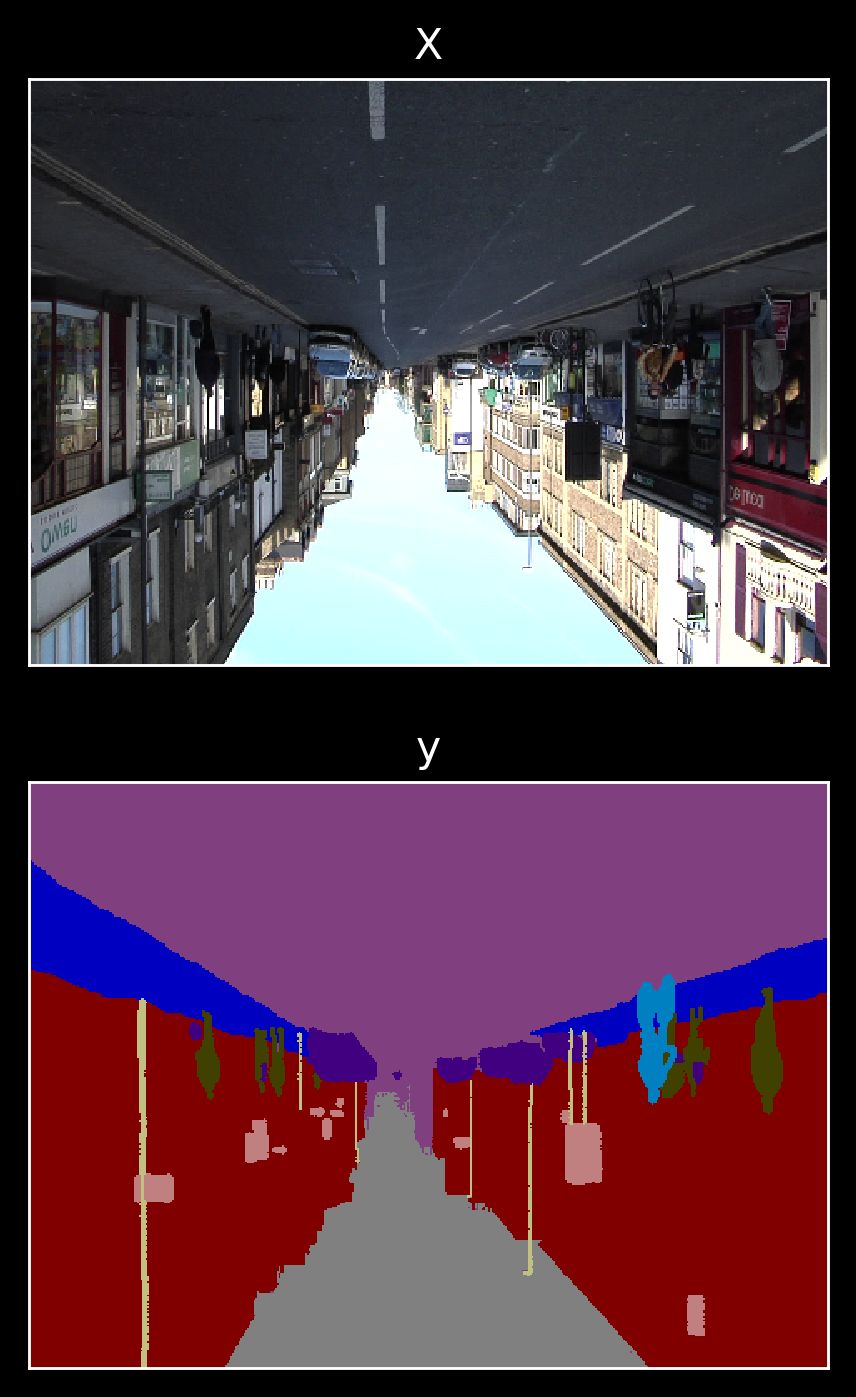

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*crop_size, 3), camvid11.n, 
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights
)

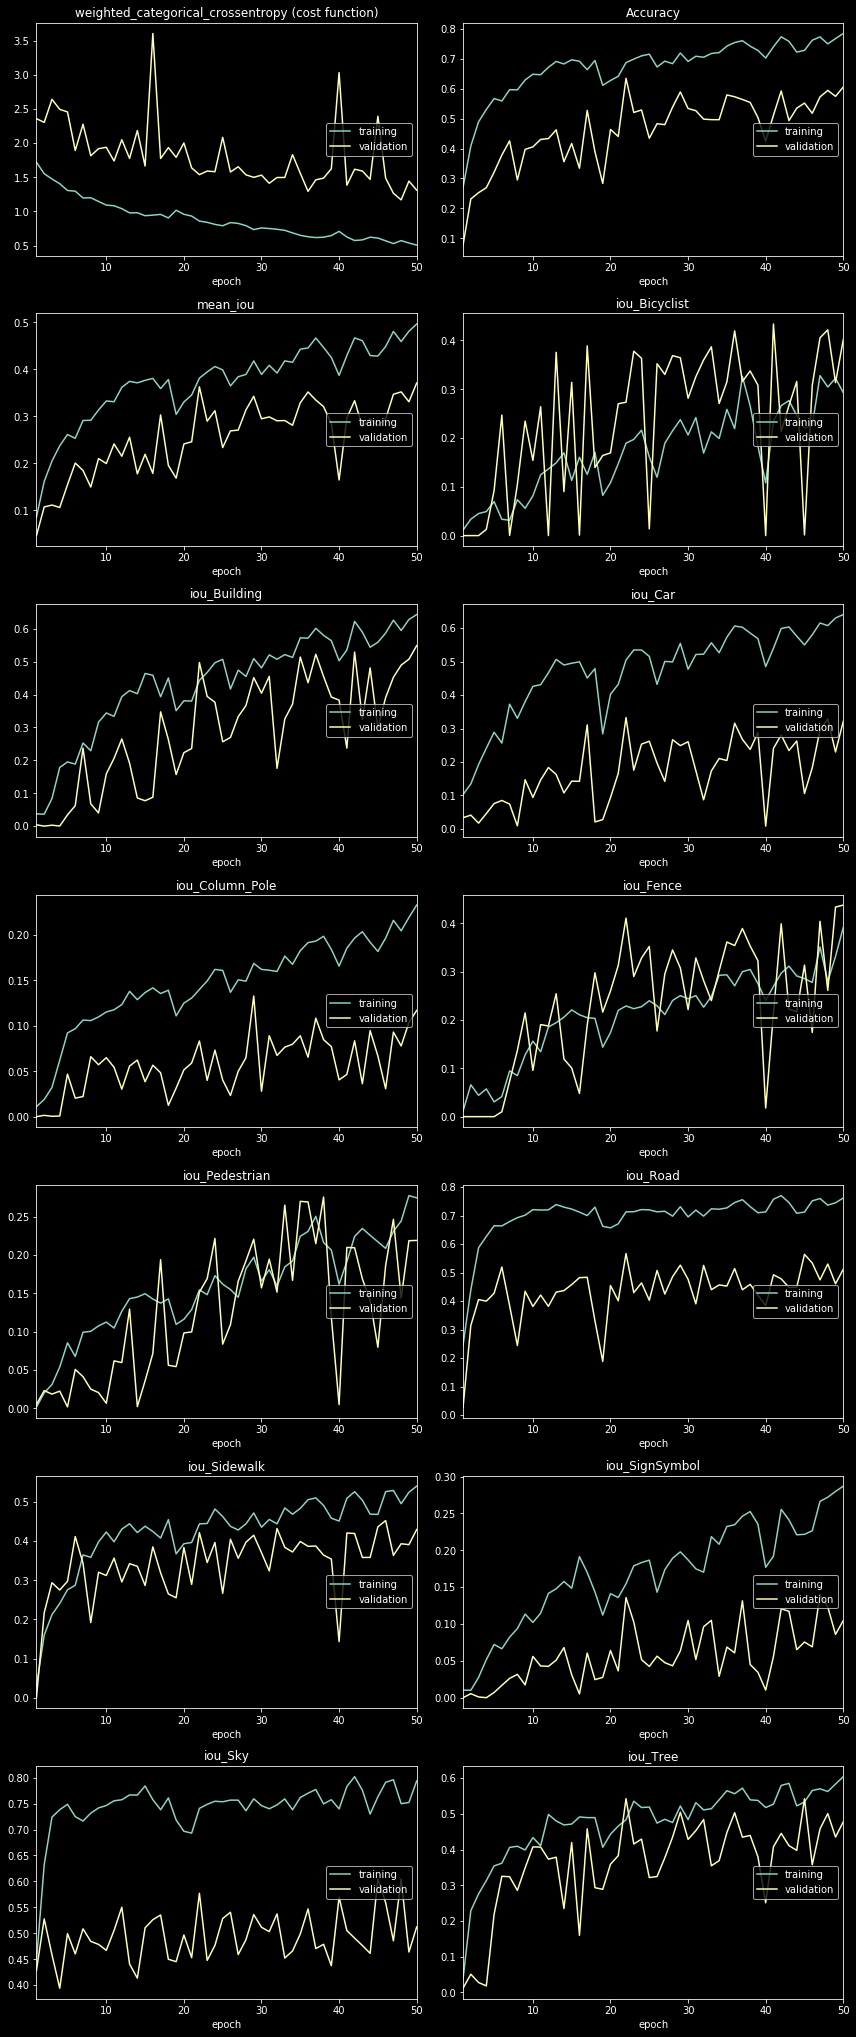

In [9]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=50,
    steps_per_epoch=int(367 / 4),
    validation_data=generators['val'],
    validation_steps=int(101 / 4),
    callbacks=[EarlyStopping(monitor='loss', patience=10), PlotLossesKeras()],
    verbose=0
)

In [10]:
history_to_results(history)

train       val
acc          0.783630  0.605301
Bicyclist    0.293063  0.401862
Building     0.643223  0.548810
Car          0.640495  0.321499
Column_Pole  0.232433  0.116935
Fence        0.391725  0.438062
Pedestrian   0.274619  0.219022
Road         0.762123  0.511772
Sidewalk     0.540657  0.429808
SignSymbol   0.287105  0.104736
Sky          0.793765  0.512169
Tree         0.603906  0.477654
loss         0.507110  1.311116
mean_iou     0.496647  0.371121

In [11]:
metrics = model.evaluate_generator(generators['test'], steps=int(233 / 4))
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss             0.612885
acc              0.840661
mean_iou         0.485506
iou_Bicyclist    0.149914
iou_Building     0.688313
iou_Car          0.639180
iou_Column_Pole  0.207784
iou_Fence        0.162744
iou_Pedestrian   0.262279
iou_Road         0.828501
iou_Sidewalk     0.696738
iou_SignSymbol   0.161242
iou_Sky          0.896308
iou_Tree         0.647563

In [12]:
X, y = next(generators['train'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

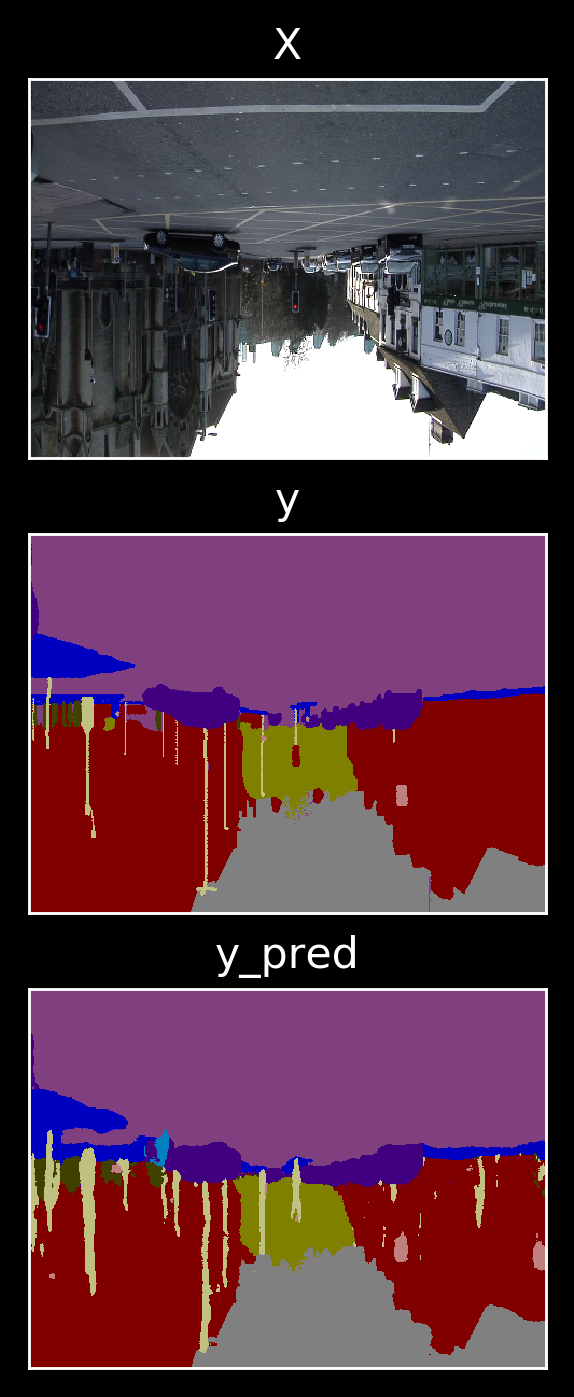

In [13]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

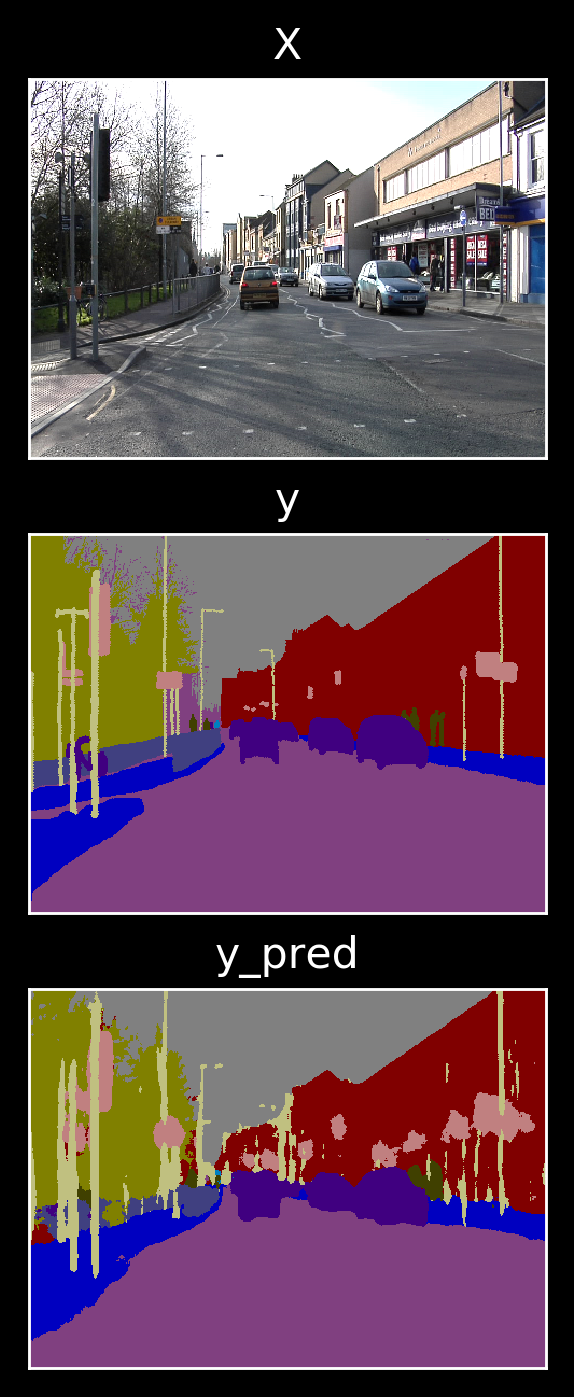

In [14]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

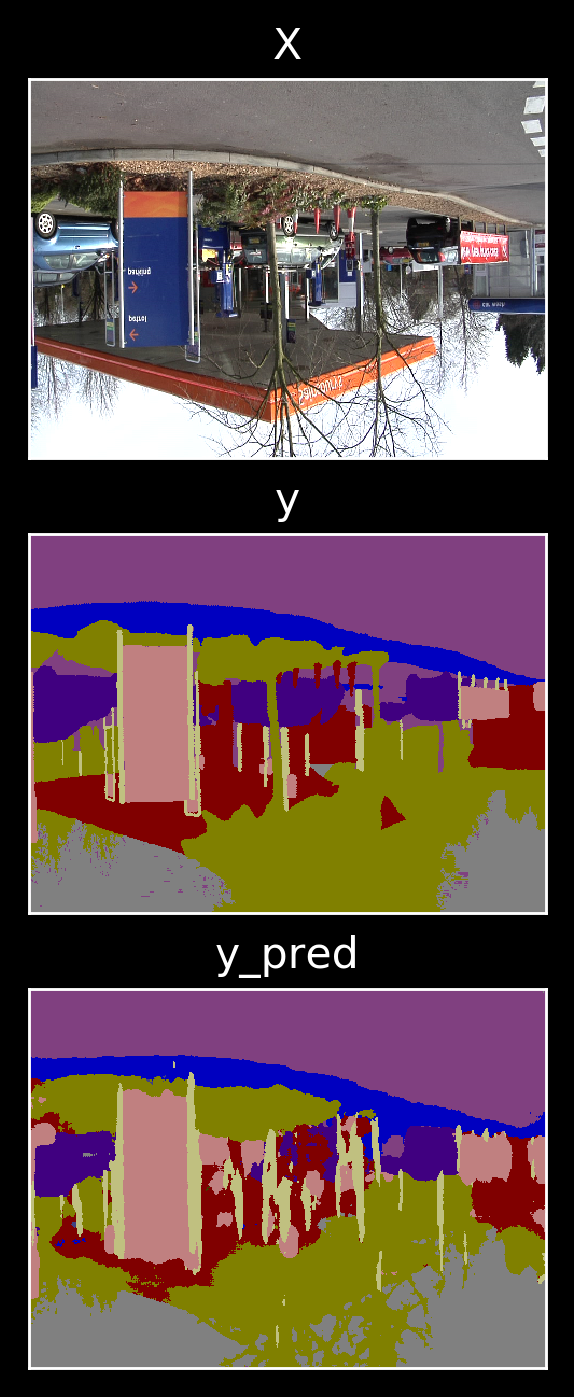

In [15]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

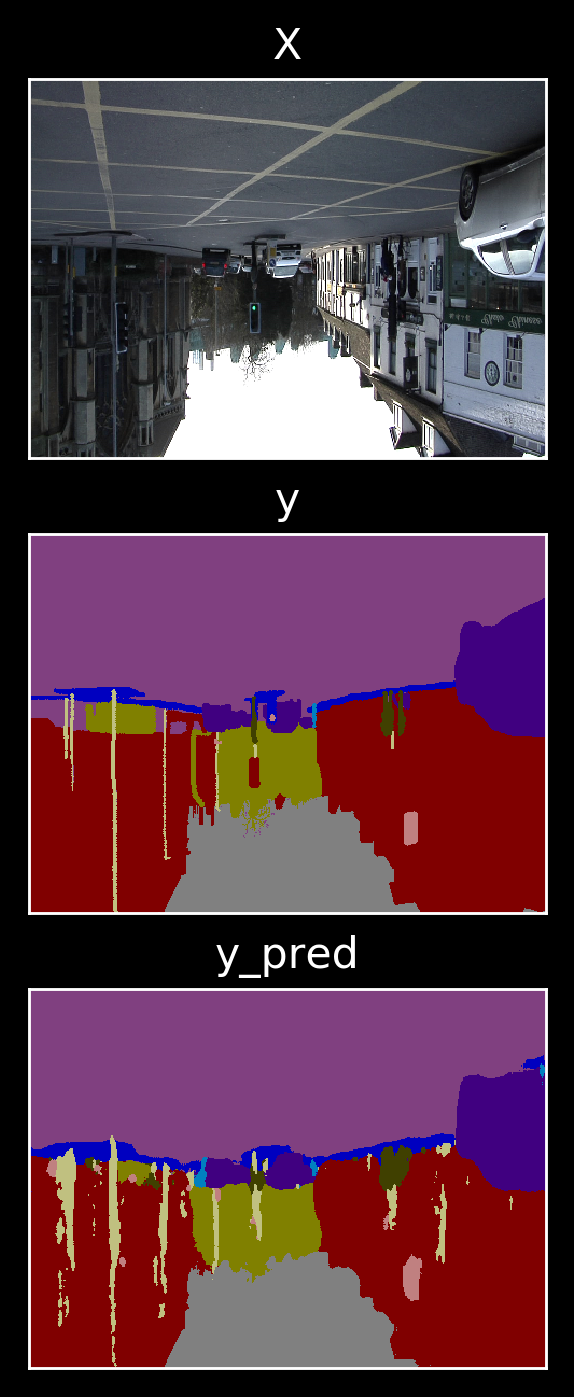

In [16]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3])

In [17]:
X, y = next(generators['val'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

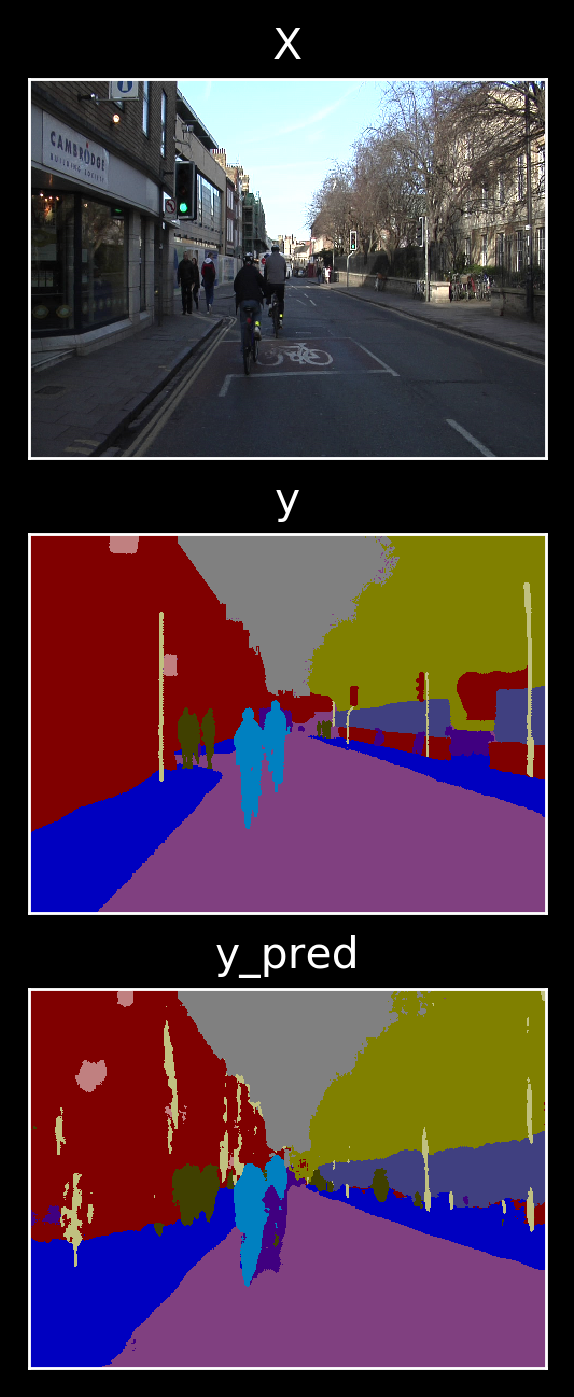

In [18]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

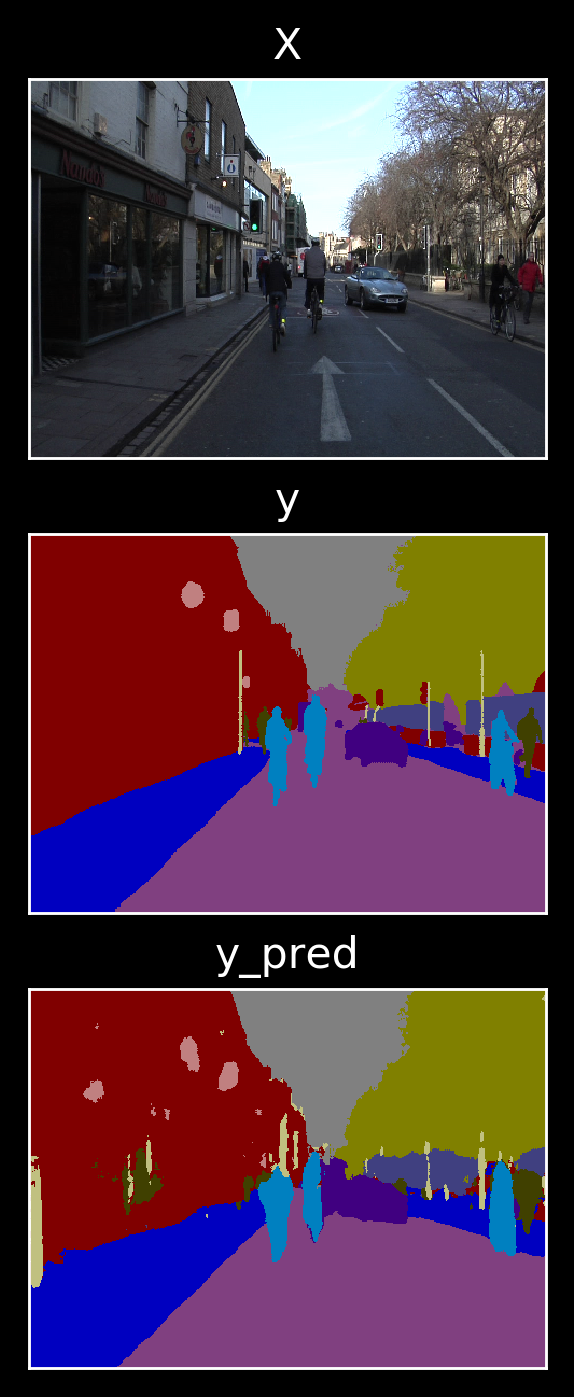

In [19]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

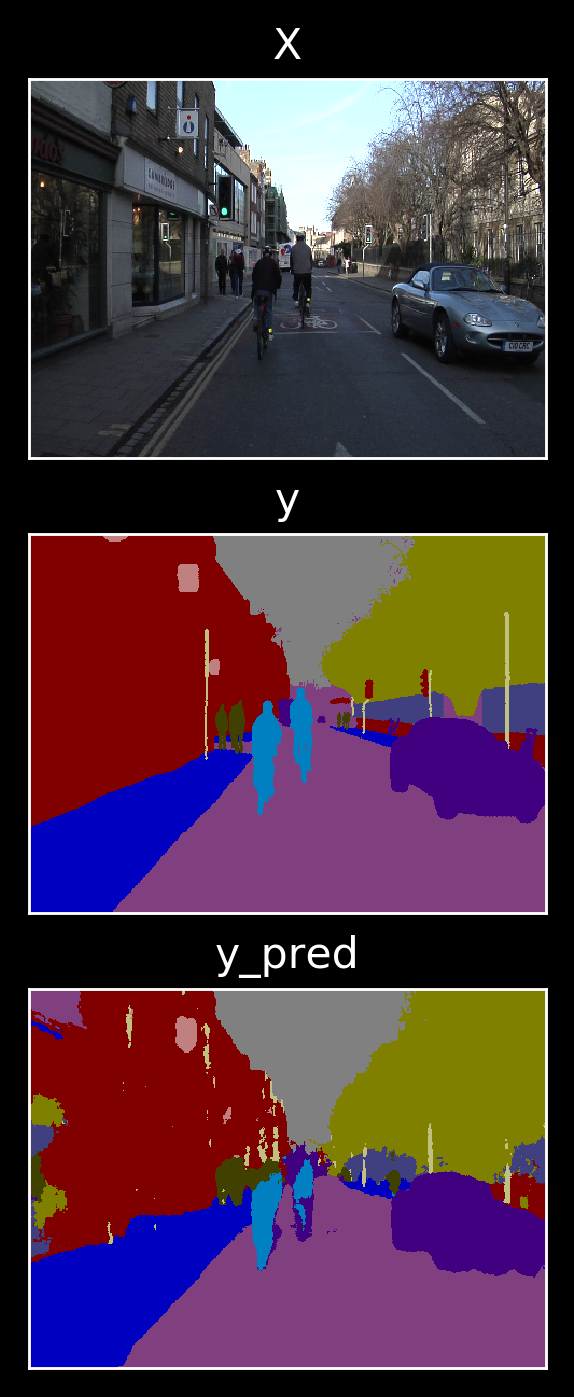

In [20]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

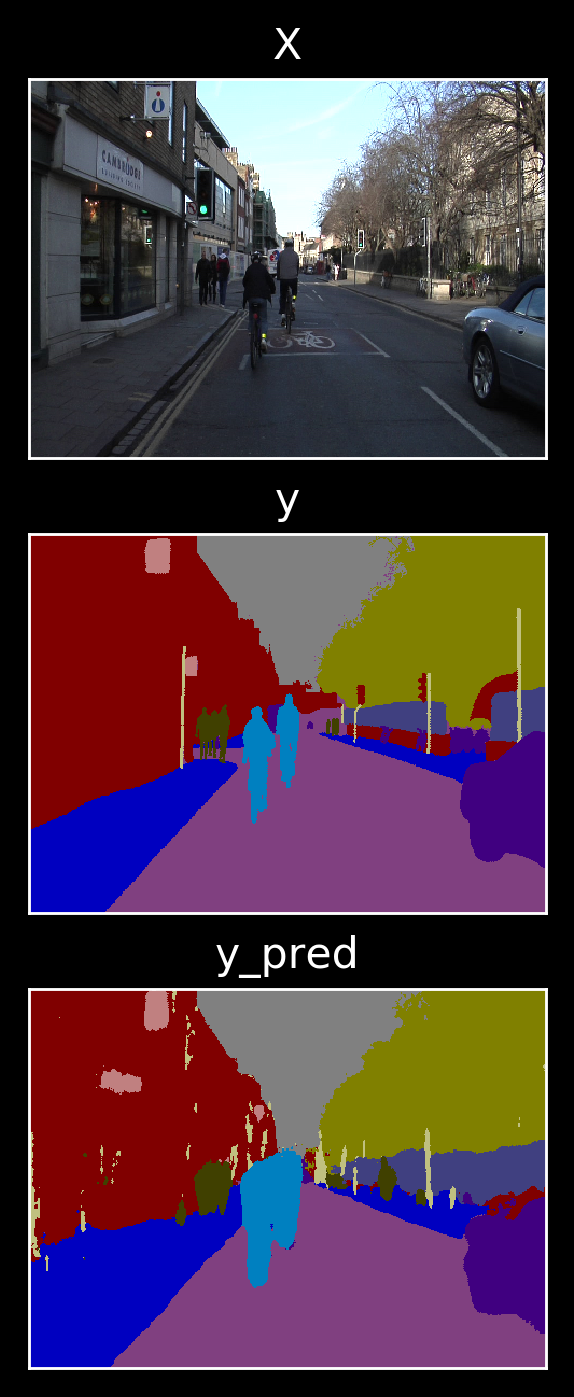

In [21]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3])

In [22]:
X, y = next(generators['test'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

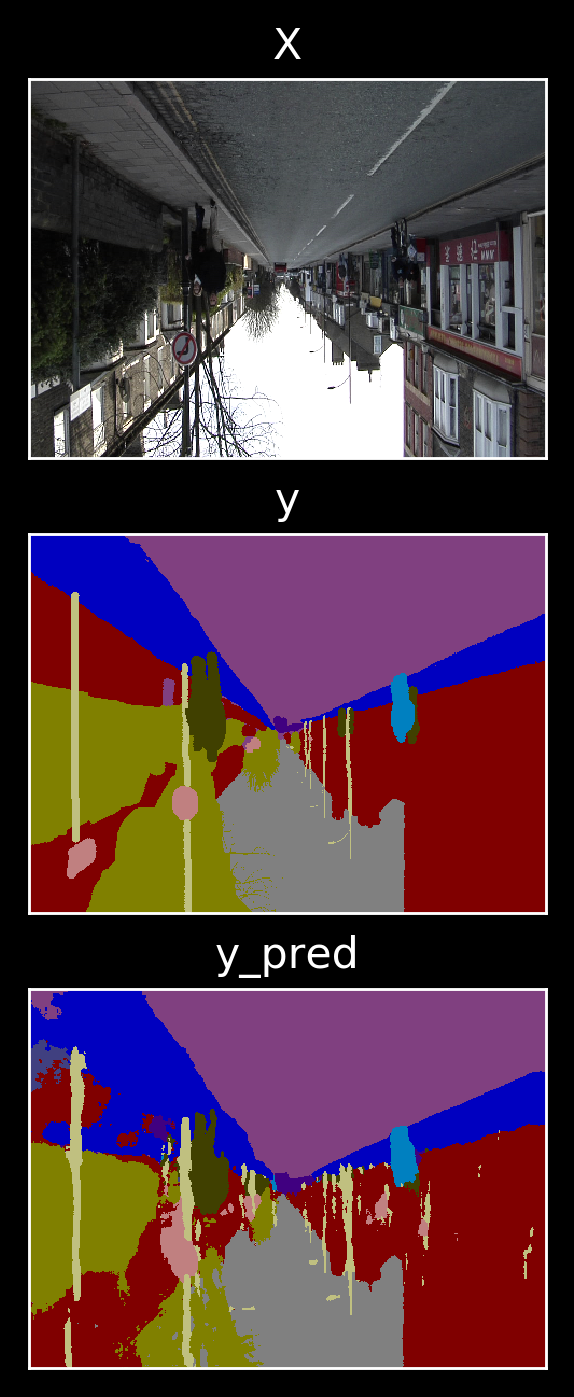

In [23]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

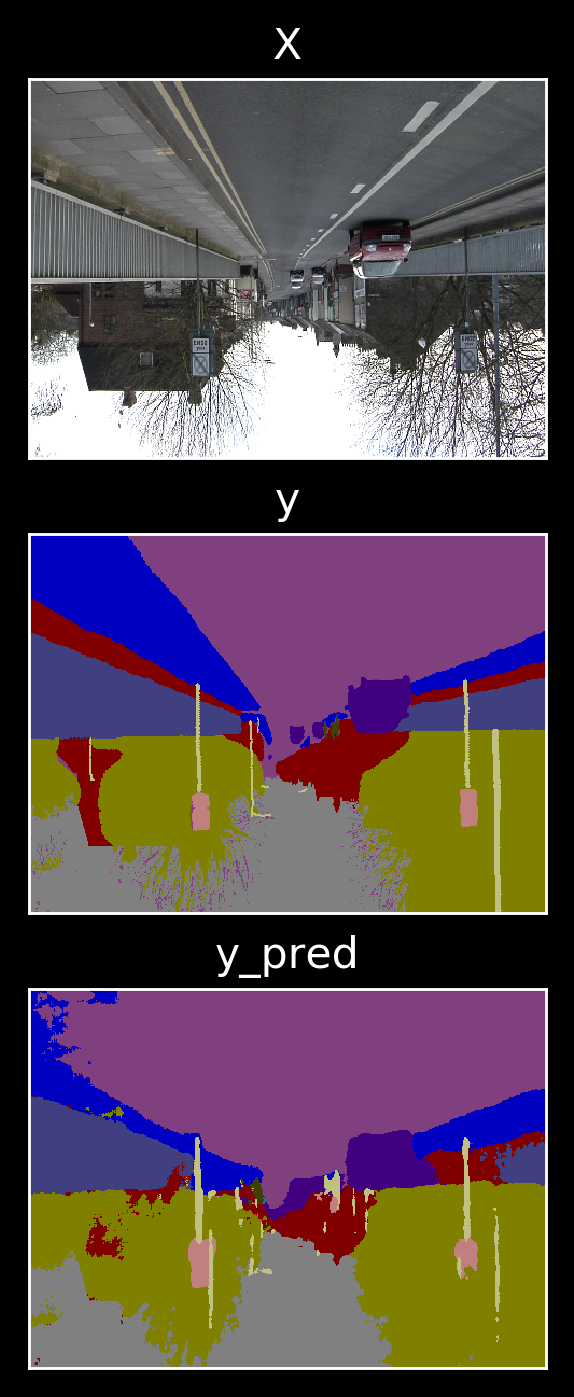

In [24]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

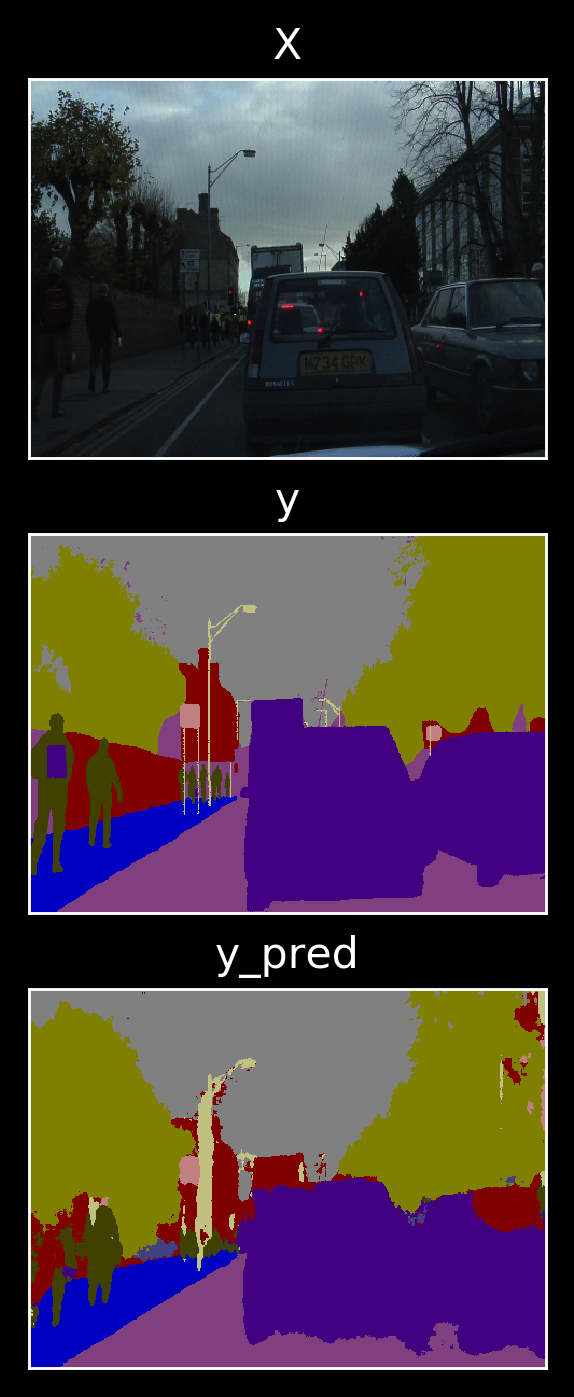

In [25]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

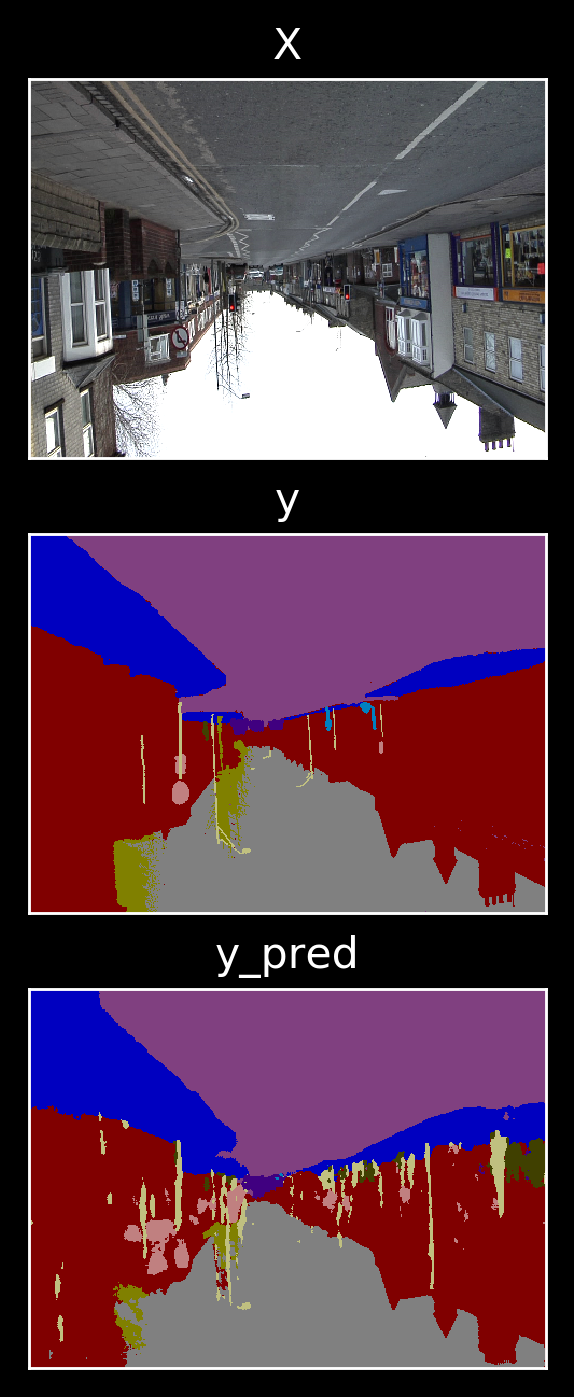

In [26]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3])

## Save Model

In [27]:
# serialize weights to HDF5
model.save_weights('models/SegNet-CamVid11.h5')